In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,38883,38919,39044,39074,39096,39145,39170,39186,39192,39227
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,12073,12226,12385,12535,12666,12787,12921,13045,13153,13259
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,49413,49623,49826,50023,50214,50400,50579,50754,50914,51067
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1564,1564,1564,1681,1681,1753,1753,1836,1836,1836
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,3848,3901,3991,4117,4236,4363,4475,4590,4672,4718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,34401,35003,35686,36151,36580,37083,37591,37963,38253,38703
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2024,2026,2026,2028,2028,2029,2029,2029,2030,2030
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14022,14070,14131,14175,14389,14443,14491,14515,14612,14641


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-01-24,-4.864593e+03,0.000000e+00,7.745230e+04,-4.864593e+03,-4.864593e+03,17497.797864,17497.797864,17497.797864,17497.797864,17497.797864,17497.797864,0.0,0.0,0.0,1.263320e+04
3,2020-01-25,-1.945128e+03,0.000000e+00,8.593589e+04,-1.945128e+03,-1.945128e+03,19563.657954,19563.657954,19563.657954,19563.657954,19563.657954,19563.657954,0.0,0.0,0.0,1.761853e+04
4,2020-01-26,9.743372e+02,0.000000e+00,7.129921e+04,9.743372e+02,9.743372e+02,3888.257866,3888.257866,3888.257866,3888.257866,3888.257866,3888.257866,0.0,0.0,0.0,4.862595e+03
7,2020-01-29,9.732733e+03,0.000000e+00,6.801797e+04,9.732733e+03,9.732733e+03,-9687.975669,-9687.975669,-9687.975669,-9687.975669,-9687.975669,-9687.975669,0.0,0.0,0.0,4.475728e+01
8,2020-01-30,1.265220e+04,0.000000e+00,7.922306e+04,1.265220e+04,1.265220e+04,3375.717764,3375.717764,3375.717764,3375.717764,3375.717764,3375.717764,0.0,0.0,0.0,1.602792e+04
9,2020-01-31,1.562971e+04,0.000000e+00,1.062499e+05,1.562971e+04,1.562971e+04,17497.797863,17497.797863,17497.797863,17497.797863,17497.797863,17497.797863,0.0,0.0,0.0,3.312751e+04
10,2020-02-01,1.860722e+04,0.000000e+00,1.119674e+05,1.860722e+04,1.860722e+04,19563.657954,19563.657954,19563.657954,19563.657954,19563.657954,19563.657954,0.0,0.0,0.0,3.817088e+04
11,2020-02-02,2.158473e+04,0.000000e+00,9.731014e+04,2.158473e+04,2.158473e+04,3888.257866,3888.257866,3888.257866,3888.257866,3888.257866,3888.257866,0.0,0.0,0.0,2.547299e+04
12,2020-02-03,2.456224e+04,0.000000e+00,7.761872e+04,2.456224e+04,2.456224e+04,-16284.277049,-16284.277049,-16284.277049,-16284.277049,-16284.277049,-16284.277049,0.0,0.0,0.0,8.277960e+03
13,2020-02-04,2.753975e+04,0.000000e+00,7.756316e+04,2.753975e+04,2.753975e+04,-18353.178729,-18353.178729,-18353.178729,-18353.178729,-18353.178729,-18353.178729,0.0,0.0,0.0,9.186568e+03


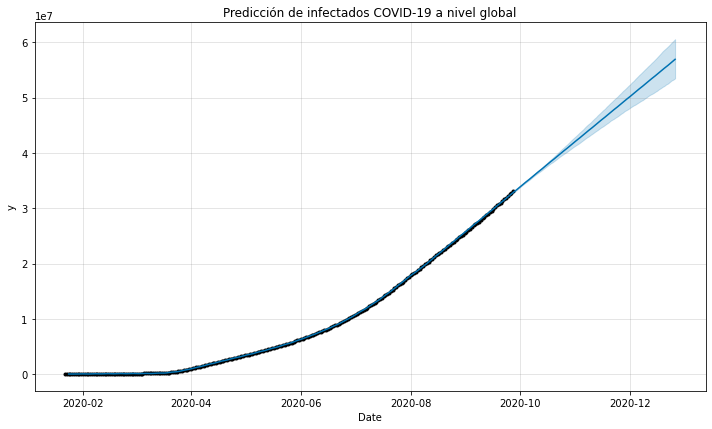

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,38883,38919,39044,39074,39096,39145,39170,39186,39192,39227
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,12073,12226,12385,12535,12666,12787,12921,13045,13153,13259
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,49413,49623,49826,50023,50214,50400,50579,50754,50914,51067
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1564,1564,1564,1681,1681,1753,1753,1836,1836,1836
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,3848,3901,3991,4117,4236,4363,4475,4590,4672,4718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,34401,35003,35686,36151,36580,37083,37591,37963,38253,38703
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2024,2026,2026,2028,2028,2029,2029,2029,2030,2030
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14022,14070,14131,14175,14389,14443,14491,14515,14612,14641


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,35
1,Albania,106
2,Algeria,153
3,Andorra,0
4,Angola,46
...,...,...
261,West Bank and Gaza,450
262,Western Sahara,0
263,Yemen,0
264,Zambia,29


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
140,Israel,3926,8655541,453.582278
19,Bahrain,586,1701582,344.385401
184,Oman,1543,5106622,302.156690
6,Argentina,8841,45195777,195.615621
168,Montenegro,116,628062,184.695142
189,Peru,5558,32971845,168.568062
150,Lebanon,1012,6825441,148.268808
223,Tunisia,1722,11818618,145.702315
86,Colombia,7018,50882884,137.924572
33,Cabo Verde,70,555988,125.901998


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



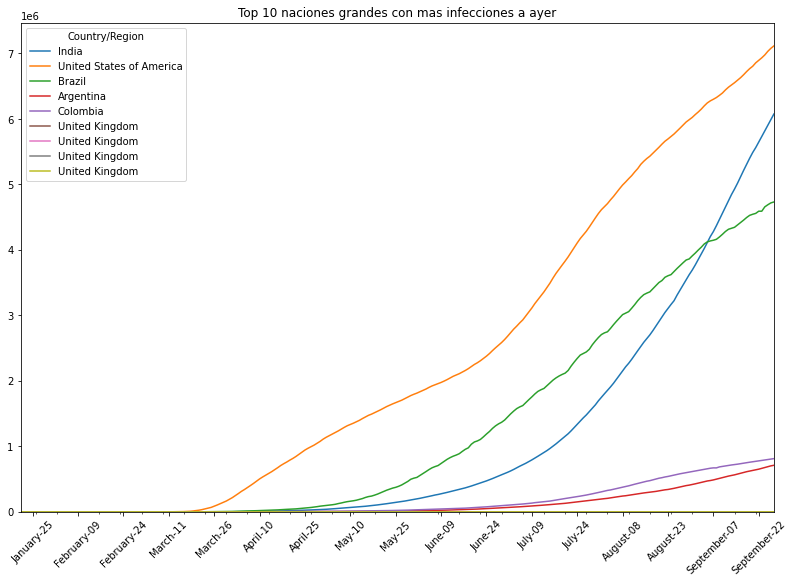

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,35,38928341,0.899088
1,Albania,106,2877800,36.833692
2,Algeria,153,43851043,3.489085
3,Andorra,0,77265,0.000000
4,Angola,46,32866267,1.399611
...,...,...,...,...
241,Uzbekistan,501,33469199,14.968987
242,Western Sahara,0,597330,0.000000
243,Yemen,0,29825967,0.000000
244,Zambia,29,18383956,1.577462


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")